### Выбор признаков изображения для дальнейших экспериментов

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern,  graycomatrix, graycoprops
import numpy as np
from scipy.ndimage import binary_dilation
from skimage import io

from common_functions import show, save_image, preprocess_image, translate_image, remove_background_gray

In [2]:
# Белый фон норм работает

# p  -> original
# p_ -> extrapolated

p1_ = 'pics/shifted_1_.png'
p2_ = 'pics/shifted_2_.png'

p1 = 'pics/shifted_1.png'
p2 = 'pics/shifted_2.png'


# исходные фрагменты
image00 = cv2.imread(p1)
#img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
i00 = remove_background_gray(cv2.cvtColor(image00, cv2.COLOR_BGR2GRAY))

image01 = cv2.imread(p2)
#img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
i01 = remove_background_gray(cv2.cvtColor(image01, cv2.COLOR_BGR2GRAY))

# ---------------------------------------------------------------

'''p1_ = 'output_fragments3/fragment_1_.png'
p2_ = 'output_fragments3/fragment_6_.png'

p1 = 'output_fragments3/fragment_1.png'
p2 = 'output_fragments3/fragment_6.png'

i00 = cv2.imread(p1, cv2.IMREAD_GRAYSCALE)
i01 = cv2.imread(p2, cv2.IMREAD_GRAYSCALE)'''

# -------------------------------------------------------------

image1 = cv2.imread(p1_, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(p2_, cv2.IMREAD_GRAYSCALE)

#image1 = preprocess_image(image1)
#image2 = preprocess_image(image2)

### Start images positions

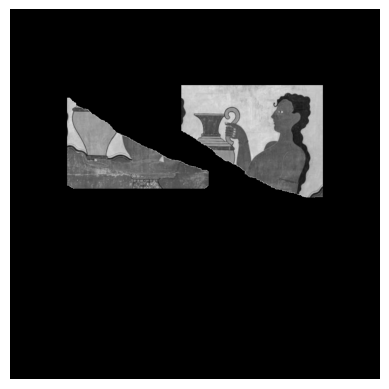

In [3]:
#result = cv2.addWeighted(i00, 0.5, i01, 0.5, -100) # for rgb 
result = cv2.bitwise_or(i00, i01)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
show(result_rgb)

In [4]:
def relative_position_fft(image1, image2):
    # Преобразование изображений в тип float32
    image1_float = np.float32(image1)
    image2_float = np.float32(image2)

    # Выполнение DFT
    dft1 = np.fft.fft2(image1_float)
    dft2 = np.fft.fft2(image2_float)

    # Сдвиг нулевой частоты в центр спектра
    # Это упрощает визуализацию и анализ частотных компонентов.
    dft1_shifted = np.fft.fftshift(dft1)
    dft2_shifted = np.fft.fftshift(dft2)

    # Вычисление взаимной корреляции
    correlation = np.fft.ifft2(dft1_shifted * np.conj(dft2_shifted))
    
    # Нормализация корреляции
    correlation = np.fft.fftshift(correlation)  # Центрируем нулевую частоту
    correlation_magnitude = np.abs(correlation)

    # Применение пороговой обработки
    threshold = 0.5 * np.max(correlation_magnitude)
    correlation_magnitude[correlation_magnitude < threshold] = 0

    # Применение ограничкений на пересечение фрагментов
    #correlation_magnitude = correlation_magnitude * inverted_corr
    #show(correlation_magnitude)

    # Находим индекс максимума
    y, x = np.unravel_index(np.argmax(correlation_magnitude), correlation_magnitude.shape)

    # Определяем смещение
    shift_y = y - image1.shape[0] // 2
    shift_x = x - image1.shape[1] // 2

    return (shift_x, shift_y)

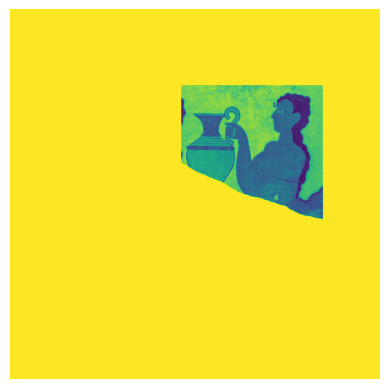

In [5]:
show(image1)

### LBP

Смещение: (np.int64(300), np.int64(100))


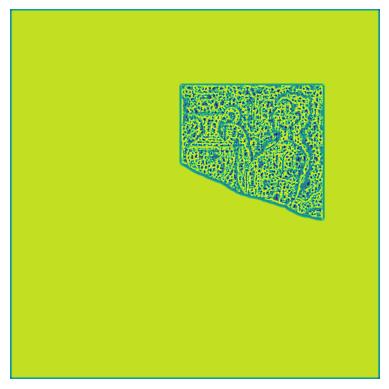

In [6]:
image1_lbp = local_binary_pattern(image1, 10, 5, method='uniform')
image2_lbp = local_binary_pattern(image2, 10, 5, method='uniform')
show(image1_lbp)

shift_lbp = relative_position_fft(image1_lbp, image2_lbp)
print(f"Смещение: {shift_lbp}")

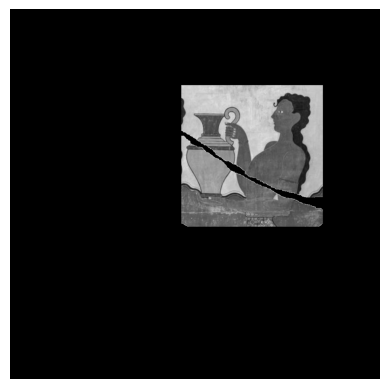

In [7]:
i00_tr = translate_image(i01, shift_lbp[0], shift_lbp[1]) #+100

result = cv2.bitwise_or(i00, i00_tr)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
show(result_rgb)

### HOG

Смещение: (np.int64(304), np.int64(96))


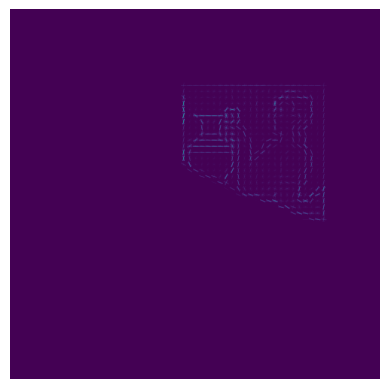

In [8]:
hog_features, image1_hog = hog(image1, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
hog_features, image2_hog = hog(image2, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
show(image1_hog)

# Нахождение относительного положения
shift_hog = relative_position_fft(image1_hog, image2_hog)
print(f"Смещение: {shift_hog}")

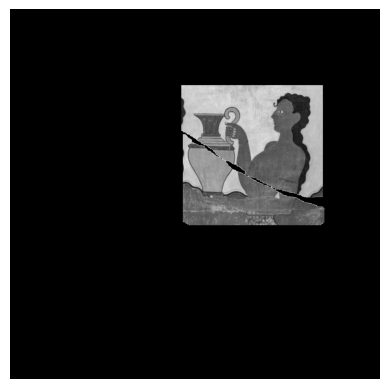

In [9]:
i00_tr = translate_image(i01, shift_hog[0], shift_hog[1])

result = cv2.bitwise_or(i00, i00_tr)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
show(result_rgb)

### Gabour Filter

In [10]:
# фильтр габора

def apply_gabor_filter(image, ksize=5, sigma=5.0, theta=5.0, lambd=5.0, gamma=0.5, psi=0):
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    
    # Применение фильтра Габора
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)
    
    # Визуализация изображения и фильтра
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(gabor_kernel, cmap='gray')
    plt.title('Gabor Kernel')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    
    plt.show()

    return filtered_image


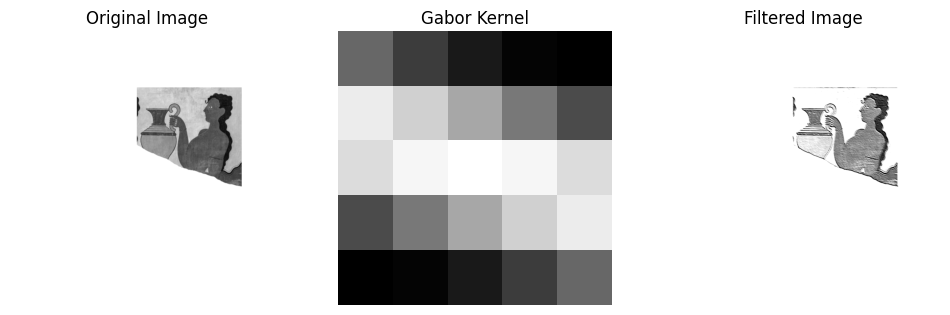

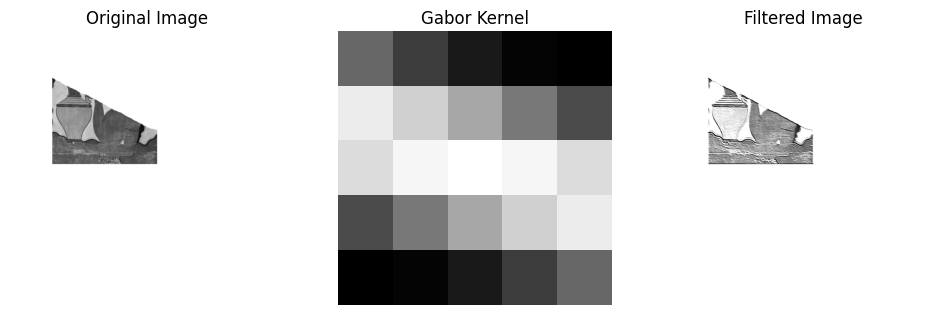

Смещение: (np.int64(300), np.int64(100))


In [11]:
# Загрузка изображений
image1_gf = apply_gabor_filter(image1)
image2_gf = apply_gabor_filter(image2)

# Нахождение относительного положения
shift_gabour = relative_position_fft(image1_gf, image2_gf)
print(f"Смещение: {shift_gabour}")

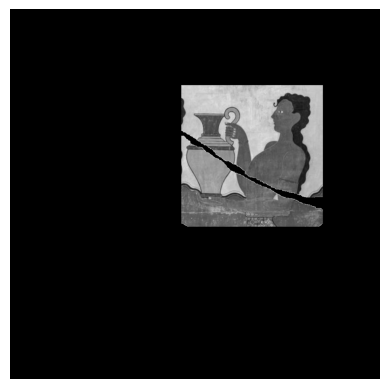

In [12]:
i00_tr = translate_image(i01, shift_gabour[0], shift_gabour[1])

result = cv2.bitwise_or(i00, i00_tr)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
show(result_rgb)

### GLCM

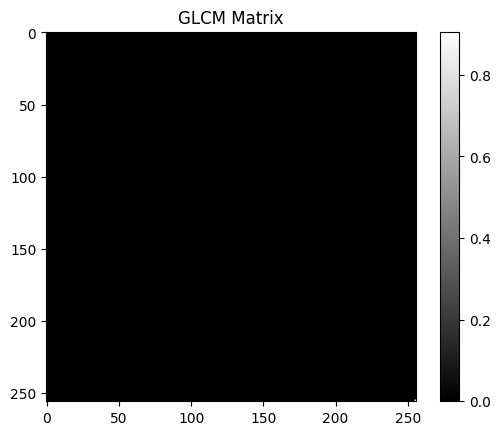

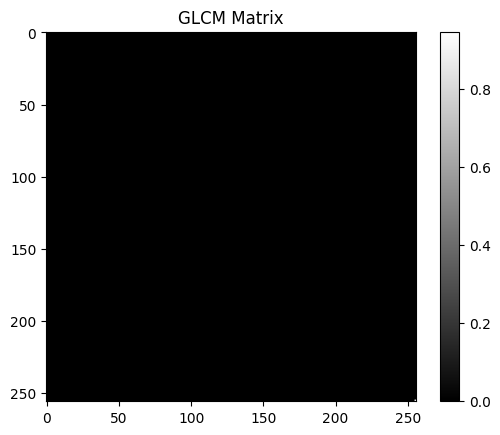

[np.float64(182.33624507874018), np.float64(2.099286417322835), np.float64(0.9189220136358948), np.float64(0.9059457284510292), np.float64(0.941350183146207), np.float64(0.8207376628986658)] [np.float64(86.46715059055121), np.float64(1.1644931102362208), np.float64(0.9523297411805166), np.float64(0.9475283459270573), np.float64(0.9515218167587698), np.float64(0.8978099663352651)]
Correlation: 0.999927999680254
Shift: (0, 0)


In [13]:
def preprocess_image(image):
    # Преобразование изображения в оттенки серого и изменение размера
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (128, 128))  # Измените размер по необходимости
    return resized_image


def calculate_glcm_features(image):
    # Вычисление GLCM
    distances = [1]  # Расстояние
    angles = [0]  # Угол
    levels = 256  # Количество уровней серого
    glcm = graycomatrix(image, distances, angles,  symmetric=True, normed=True, levels=levels)

    # Визуализация GLCM
    plt.imshow(glcm[:, :, 0, 0], cmap='gray')
    plt.title('GLCM Matrix')
    plt.colorbar()
    plt.show()

    # Извлечение текстурных признаков
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]  # Ассоциированная сумма квадратов

    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]


def relative_position_glcm(image1, image2):
    # Предварительная обработка изображений
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Вычисление GLCM признаков
    features1 = calculate_glcm_features(image1)
    features2 = calculate_glcm_features(image2)
    
    # Сравнение признаков (можно использовать различные метрики)
    correlation = np.dot(features1, features2) / (np.linalg.norm(features1) * np.linalg.norm(features2))

    print(features1, features2)

    # Визуализация признаков
    # Определение смещения с использованием cv2.matchTemplate
    result = cv2.matchTemplate(image1, image2, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Определение смещения
    shift_x, shift_y = max_loc
    
    plt.show()

    return correlation, (shift_x, shift_y)


image1 = io.imread(p1)  
image2 = io.imread(p2)  

correlation, shift_glcm = relative_position_glcm(image1, image2)
print(f'Correlation: {correlation}')
print(f'Shift: {shift_glcm}')

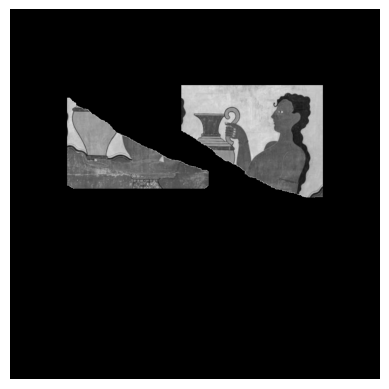

In [14]:
i00_tr = translate_image(i01, shift_glcm[0], shift_glcm[1])

result = cv2.bitwise_or(i00, i00_tr)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
show(result_rgb)